In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import time

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

%matplotlib inline

from sklearn.model_selection import train_test_split



In [2]:
# læs data 
df_est = pd.read_pickle('job_kurser.pkl')

print(df_est.head())


# def dan_xy(index) :
#     y = np.array((np.log(df_est.iloc[index])))
#     X = np.array((np.log(df_est.iloc[index+14]))).reshape(-1, 1)
#     return X, y

# X, y = dan_xy(7)
# X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
# X_train, X_eval, y_train, y_eval = train_test_split(X_dev, y_dev, test_size=.25, random_state=2)

# X_train


             Carlsberg   Coloplast  Danske Bank         DSV  Jyske Bank  \
Date                                                                      
2007-01-31  456.189545  101.200000   235.768773  102.263636  397.664091   
2007-02-28  480.336250  100.815000   247.720700   99.975000  428.416050   
2007-03-31  470.682727   94.413636   233.739318   96.081818  400.536455   
2007-04-30  485.811778   94.594444   237.665111  103.672222  418.761556   
2007-05-31  528.809850   97.145000   226.807400  115.155000  404.439550   

               Nordea  Novo Nordisk   Novozymes     Vestas        Tryg  \
Date                                                                     
2007-01-31  89.079545     48.022727  102.440909  90.772727  242.977273   
2007-02-28  90.075000     51.272500   99.295000  93.835000  277.125000   
2007-03-31  86.704545     48.602273   98.013636  90.781818  284.295455   
2007-04-30  92.750000     53.472222  104.655556  93.572222  343.833333   
2007-05-31  92.850000     57.0

## Structure data

In [3]:
col_kurs = list(df_est.iloc[:,:13])
col_post = list(df_est.iloc[:,-13:])
print(col_post)
l = len(df_est)

container = pd.DataFrame(columns=['stock_price', 'job_postings', 'company'])
for i in range(len(col_kurs)) :
    yserie = np.log(df_est[col_kurs[i]]).shift(periods=-1)
    xserie = (df_est[col_post[i]])
    tmp = pd.DataFrame(pd.concat([yserie.iloc[:-1], xserie.iloc[:-1]], axis=1, ignore_index=True))
    tmp.columns=(['stock_price', 'job_postings'])
    tmp['company']=col_kurs[i]
    container = pd.concat([container, tmp], axis=0, ignore_index=True)
print(container.head())

['Carlsberg_jobs', 'Coloplast_jobs', 'Danske_Bank_jobs', 'DSV_jobs', 'Jyske_Bank_jobs', 'Nordea_jobs', 'Novo_Nordisk_jobs', 'Novozymes_jobs', 'Vestas_jobs', 'Tryg_jobs', 'H_Lundbeck_jobs', 'Alm_Brand_jobs', 'SAS_jobs']
   stock_price job_postings    company
0     6.174486           22  Carlsberg
1     6.154184            8  Carlsberg
2     6.185821           16  Carlsberg
3     6.270629           30  Carlsberg
4     6.275957            9  Carlsberg


In [4]:
container0 = container.fillna(0)#nan_to_num(container)
#banks=['Carlsberg', 'Coloplast', 'Danske Bank', 'DSV', 'Jyske Bank', 'Nordea', 'Novo Nordisk', 'Novozymes', 'Vestas', 'Tryg', 'H. Lundbeck', 'Alm. Brand', 'SAS']
banks=['Nordea', 'Danske Bank', 'Jyske Bank']
df_bank = container0[container0.company.isin(banks)]

#input_data = pd.get_dummies(container0, columns=['company'])
input_data = pd.get_dummies(df_bank, columns=['company'], drop_first=True)
#print(input_data)
features = list(input_data.iloc[:,1:])

input_data_l1 = input_data.shift()

# dan X og y
y = np.array(input_data['stock_price'])
X = np.array(input_data.iloc[:,1:])

# dan training og test
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_dev.shape, y_dev.shape)
print(X_test.shape, y_test.shape)
y = np.nan_to_num(y, copy=False)



(105, 3) (105,)
(36, 3) (36,)


## Regression

Predicted data: Mean=4.8484, STD=0.6086 and VAR=0.3704.
Measured data: Mean=4.8513, STD=0.5668 and VAR=0.3213.
The function:
y = 4.769 + 0.2813 * x0 + 0.3111 * x1 + -0.417 * x2

Intercept : 4.769
x0 = job_postings : 0.281
x1 = company_Jyske Bank : 0.311
x2 = company_Nordea : -0.417

R^2 Train: 0.813, test: 0.832
Mean squared error: 0.05385


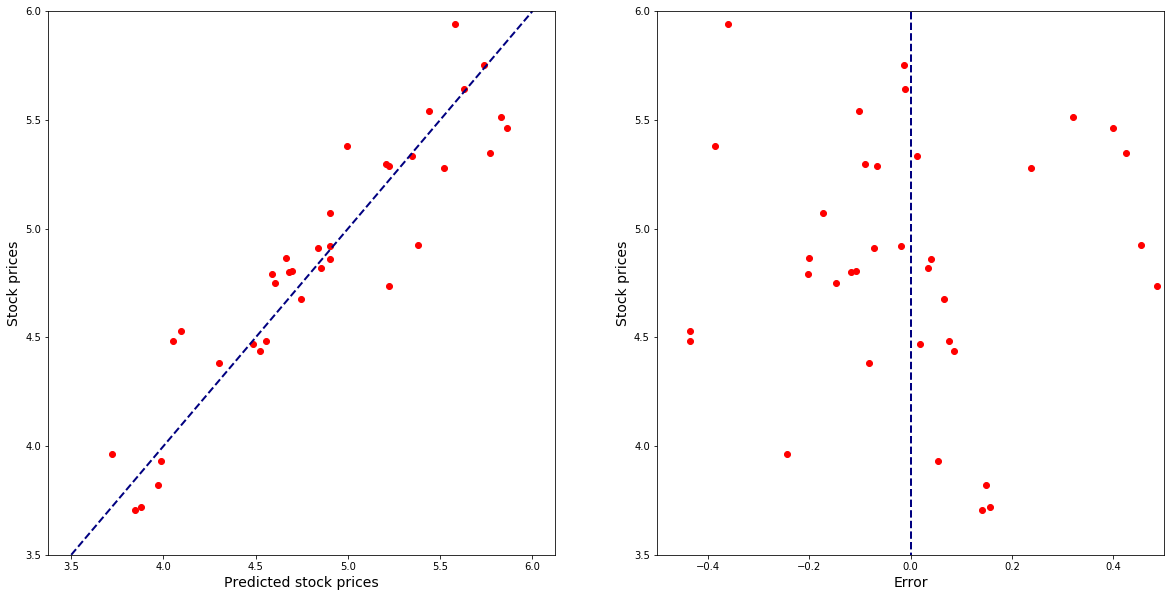

In [54]:

pipe_lr = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

feature_names = pipe_lr.named_steps.polynomialfeatures.get_feature_names()
coefficients = pipe_lr.named_steps.linearregression.coef_
intercept = pipe_lr.named_steps.linearregression.intercept_

#print("Beta =", pipe_lr.coef_[0])
#print('Alpha = ', pipe_lr.intercept_)

y_dev_hat = pipe_lr.predict(X_dev)
y_test_hat = pipe_lr.predict(X_test)

print("Predicted data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test_hat), 4), round(np.std(y_test_hat), 4), round(np.var(y_test_hat), 4)))
print("Measured data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test), 4), round(np.std(y_test), 4), round(np.var(y_test), 4)))

# print model info
print("The function:")
print('y =', round(intercept, 4), end='')
for i in range(len(feature_names)) :
    print(' +', round(coefficients[i], 4), "*", feature_names[i], end='')
print('\n')
print('Intercept :', round(intercept, 3))
for i in range(len(features)) :
    print(feature_names[i], "=", features[i], ":", round(coefficients[i], 3))
    
print('\nR^2 Train: %.3f, test: %.3f' % (r2_score(y_dev, y_dev_hat), r2_score(y_test, y_test_hat)))
print('Mean squared error: {}'.format(round(mse(y_test, y_test_hat),5)))


# make plot
font = {'size': 14,}

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_ylim(3.5,6)
ax[0].set_ylabel(ylabel='Stock prices', fontdict=font)
ax[0].set_xlabel(xlabel='Predicted stock prices', fontdict=font)

ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
ax[1].set_xlabel(xlabel='Error', fontdict=font)
ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax[0].scatter(pipe_lr.predict(X_test), y_test, color='red')
ax[1].scatter((pipe_lr.predict(X_test))-y_test, y_test, color='red')
ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

plt.savefig('Fig_LinReg_lag(-1)_banks.png')

## Lasso

### Pure lasso

In [6]:
perform = []

kfolds = KFold(n_splits=3)

mseCV = []

alphas =  np.logspace(-5, 4, 12)

for alpha_ in alphas:
    
    pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=alpha_, random_state=1))
    mseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 

        pipe_lassoCV.fit(X_dev, y_dev)
        
        msetest = mse(pipe_lassoCV.predict(X_test), y_test)
        mseCV_.append(msetest)    
    mseCV.append(np.mean(mseCV_))

optimal = pd.Series(mseCV,index=alphas).nsmallest(1)
print("Optimal alpha")
print("alpha"," "*5, "Mean MSE")
print(optimal)
mseCV



Optimal alpha
alpha       Mean MSE
0.018738    0.049993
dtype: float64


[0.053844435775214944,
 0.05383030017816385,
 0.05373769406246524,
 0.05314557872127348,
 0.04999314944903605,
 0.06142770512953119,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138,
 0.3280461910371138]

Predicted data: Mean=4.847, STD=0.5803 and VAR=0.3367.
The function:
y = 4.769 + 0.2564 * x0 + 0.2978 * x1 + -0.3994 * x2

x0 = job_postings
x1 = company_Jyske Bank
x2 = company_Nordea

R^2 Train: 0.811, test: 0.844
Mean squared error: 0.04999


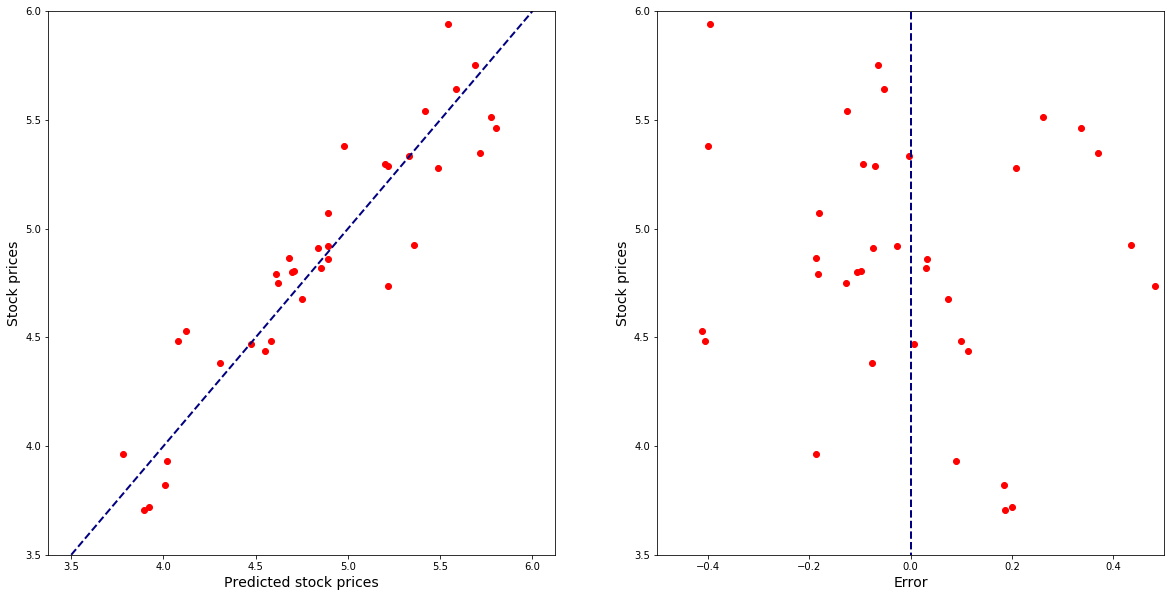

In [5]:
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=0.018738, random_state=1))
pipe_lasso.fit(X_dev, y_dev)

y_dev_hat = pipe_lasso.predict(X_dev)
y_test_hat = pipe_lasso.predict(X_test)

feature_names = pipe_lasso.named_steps.polynomialfeatures.get_feature_names()
coefficients = pipe_lasso.named_steps.lasso.coef_
intercept = pipe_lasso.named_steps.lasso.intercept_

# print model info
print("Predicted data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test_hat), 4), round(np.std(y_test_hat), 4), round(np.var(y_test_hat), 4)))

print("The function:")
print('y =', round(intercept, 4), end='')
for i in range(len(feature_names)) :
    print(' +', round(coefficients[i], 4), "*", feature_names[i], end='')
print('\n')
for i in range(len(features)) :
    print(feature_names[i], "=", features[i])
    
print('\nR^2 Train: %.3f, test: %.3f' % (r2_score(y_dev, y_dev_hat), r2_score(y_test, y_test_hat)))

print('Mean squared error: {}'.format(round(mse(y_test, y_test_hat),5)))

# make plot
font = {'size': 14,}

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_ylim(3.5,6)
ax[0].set_ylabel(ylabel='Stock prices', fontdict=font)
ax[0].set_xlabel(xlabel='Predicted stock prices', fontdict=font)

ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
ax[1].set_xlabel(xlabel='Error', fontdict=font)
ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax[0].scatter(y_test_hat, y_test, color='red')
ax[1].scatter((y_test_hat - y_test), y_test, color='red')
ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

plt.savefig('Fig_lasso_lag(-1)_banks.png')




In [31]:
# y_test, y_test_hat
q = np.concatenate([y_test, X_test], axis=1)
#print(q)
q1 = X_test[X_test[:,1] == 0]
q2 = q1[q1[:,2] == 0]

y_test_hat = pipe_lasso.predict(q2)
q2 = q2[:,0]
print(y_test.shape, y_test_hat.shape, q2.shape)
fig, ax = plt.subplots(figsize=(10,5))
#ax[0].set_ylim(3.5,6)
ax.set_xlabel(xlabel='Job postings', fontdict=font)
ax.set_ylabel(ylabel='Stock prices', fontdict=font)

#ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
# ax[1].set_xlabel(xlabel='Error', fontdict=font)
# ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax.scatter(q2, y_test_hat, color='red')
#ax.scatter(q2, y_test, color='blue')
#ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

#ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

#plt.savefig('Fig_lasso_lag(-1)_banks.png')


AxisError: axis 1 is out of bounds for array of dimension 1

### kFold and Ridge

In [58]:

kfolds = KFold(n_splits=3)

mseCV = []

lambdas =  np.logspace(-5, 4, 12)

for lambda_ in lambdas:
   
    pipe_RidgeCV = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Ridge(alpha=lambda_, random_state=1))    
    mseCV_ = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 

        pipe_RidgeCV.fit(X_dev, y_dev)
        
        msetest = mse(pipe_RidgeCV.predict(X_test), y_test)
        mseCV_.append(msetest)    
    mseCV.append(np.mean(mseCV_))

optimal = pd.Series(mseCV,index=lambdas).nsmallest(1)
print("Optimal lambda")
print("lambda"," "*5, "Mean MSE")
print(optimal)


Optimal lambda
lambda       Mean MSE
5.336699    0.050865
dtype: float64


Predicted data: Mean=4.8458, STD=0.5841 and VAR=0.3412.
The function:
y = 4.769 + 0.262 * x0 + 0.3036 * x1 + -0.3963 * x2

x0 = job_postings
x1 = company_Jyske Bank
x2 = company_Nordea

R^2 Train: 0.811, test: 0.842
Mean squared error: 0.05087


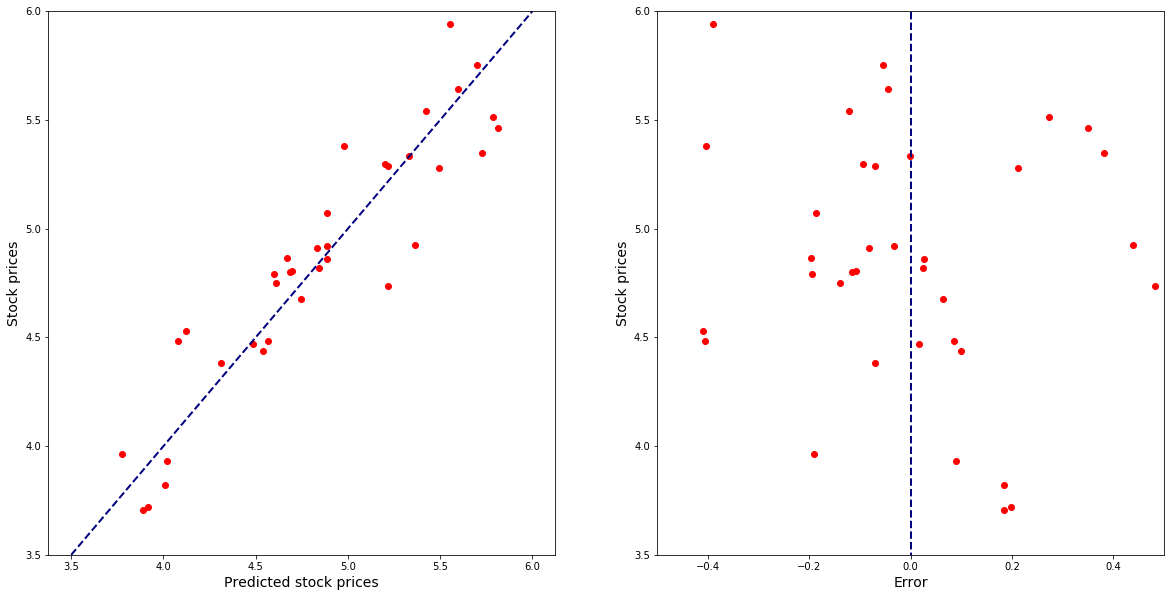

In [60]:
pipe_Ridge = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                 StandardScaler(),
                                 Ridge(alpha=5.336699, random_state=1))    
pipe_Ridge.fit(X_dev, y_dev)

y_dev_hat = pipe_Ridge.predict(X_dev)
y_test_hat = pipe_Ridge.predict(X_test)

feature_names = pipe_Ridge.named_steps.polynomialfeatures.get_feature_names()
coefficients = pipe_Ridge.named_steps.ridge.coef_
intercept = pipe_Ridge.named_steps.ridge.intercept_

# print model info
print("Predicted data: Mean={}, STD={} and VAR={}.".
      format(round(np.mean(y_test_hat), 4), round(np.std(y_test_hat), 4), round(np.var(y_test_hat), 4)))

print("The function:")
print('y =', round(intercept, 4), end='')
for i in range(len(feature_names)) :
    print(' +', round(coefficients[i], 4), "*", feature_names[i], end='')
print('\n')
for i in range(len(features)) :
    print(feature_names[i], "=", features[i])
    
print('\nR^2 Train: %.3f, test: %.3f' % (r2_score(y_dev, y_dev_hat), r2_score(y_test, y_test_hat)))

print('Mean squared error: {}'.format(round(mse(y_test, y_test_hat),5)))

# make plot
font = {'size': 14,}

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_ylim(3.5,6)
ax[0].set_ylabel(ylabel='Stock prices', fontdict=font)
ax[0].set_xlabel(xlabel='Predicted stock prices', fontdict=font)

ax[1].set(ylim=(3.5,6), xlim=(-.5, .5))
ax[1].set_xlabel(xlabel='Error', fontdict=font)
ax[1].set_ylabel(ylabel='Stock prices', fontdict=font)

ax[0].scatter(y_test_hat, y_test, color='red')
ax[1].scatter((y_test_hat - y_test), y_test, color='red')
ax[1].vlines(x=0, ymin=2.5, ymax=6.5, color='navy', lw=2, linestyle='--')

ax[0].plot([3.5, 6], [3.5, 6], color='navy', lw=2, linestyle='--')

plt.savefig('Fig_Ridge_lag(-1)_banks.png')

## Bag of words

### Stopwords

In [119]:
import nltk
stopwords = nltk.corpus.stopwords.words('danish')


### Get data and fit the CountVectorizer

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

ny1 = pd.read_pickle('both1.pkl')
ny2 = pd.read_pickle('both2.pkl')
ny4 = pd.read_pickle('both4.pkl')

df_both = pd.concat([ny1, ny2, ny4], axis=0, join='inner', ignore_index=True)

#print("Shape", df_both.shape)
#print("\n")
#print(df_both.head(1), "\n", df_both.tail(2))

desc = df_both.sample(60000, random_state=5)

#print(desc)


t0 = time.time()

count=TfidfVectorizer(ngram_range=(1, 3), max_df=.1, max_features=5000)
bag = count.fit_transform(desc['job_describ'].values)

t1 = time.time()

print("Procestid er", int((t1-t0)/60), "minutter og", round((t1-t0)%60, 2), "sekunder")

# 10000 linier: Procestid er 0 minutter og 0.78 sekunder

Procestid er 0 minutter og 17.5 sekunder


In [136]:
t0 = time.time()

X = count.transform(desc['job_describ'])

t1 = time.time()

print("Procestid er", int((t1-t0)/60), "minutter og", round((t1-t0)%60, 2), "sekunder")

# 10000 linier: Procestid er 0 minutter og 0.49 sekunder

Procestid er 0 minutter og 6.59 sekunder


In [137]:
print(X.shape)
# print(type(X))


(60000, 5000)


## LatentDirichletAllocation

In [138]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=20, random_state=5, learning_method='batch')
t0 = time.time()

X_topics = lda.fit_transform(X)

t1 = time.time()

print("Procestid er {} minutter og {} sekunder".format(int((t1-t0)/60),round((t1-t0)%60, 2)))

# 10000 linier: Procestid er 0 minutter og 30.01 sekunder

Procestid er 2 minutter og 25.17 sekunder


In [91]:
print(lda.components_.shape)


(10, 2000)


In [139]:
n_top_words = 15
feature_names = count.get_feature_names()
for cat_idx, cat in (enumerate(lda.components_)) :
    print("Category %d:" % (cat_idx + 1))
    print(" ".join([feature_names[i] for i in cat.argsort()[:-n_top_words - 1:-1]]))
    

Category 1:
medarbejder muligt medarbejder til rengøring vi søger hurtigst hurtigst muligt en medarbejder til rengøring vi søger en frisk mangler och muligt en søges
Category 2:
kan det er du dig så skal kan du have god du er måske være for at så er du skal
Category 3:
timer pr 37 37 timer uge pædagog 30 snarest eller ugen 2009 om ugen 2010 pr uge timer pr
Category 4:
være være med vil du du være vil du være med til med til at være med til du være med del af en del en del af være en udvikle være en del
Category 5:
søges søges til dygtig til vores søger vi vi søger en dygtig snarest tiltrædelse vi søger en søger vi en vi en søges en job fra et job fra
Category 6:
efter løn overenskomst aftale efter aftale løn efter eller efter henhold henhold til nyt eller efter aftale løn og et nyt mail løn efter aftale
Category 7:
for at blive oprettet konsulenter kontakt med en vores konsulenter med en af du kontakt du kontakt med blive oprettet af vores konsulenter at blive virksomhedsbruger skal du

In [86]:
cat5 = X_topics[:, 4].argsort()[::-1]

for iter_idx, post_idx in enumerate(cat5[:3]) :
#    print(iter_idx, post_idx)
    print(desc['job_describ'].iloc[post_idx], "\n")

Sondrup Bilcenter A/S er en moderne handelsvirksomhed i stadig ekspansion. Vi er autoriseret Volvo og Renault forhandler, og har 5 afdelinger i Østjylland, med hovedkontor i Viby. Sondrup Bilcenter A/S ha 

Hos Euromaster Danmark A/S har vi søger vi en montør/udemontør til vores center i Skejby Om jobbet: - Montering af dæk på biler lastbiler og... 

Er du en ildsjæl der har lyst til at være med på holdet der udvikler fælles ledelsesinformation i en af Danmarks største virksomheder - så... 

